<table width="100%">
    <td align="left">
        <a target="_blank", href="https://www.up.pt/fcup/en/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2023/03/FCUP_logo-print_blcktransp_600ppi.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td>
        <a target="_blank", href="https://www.iastro.pt/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2018/03/IA_logo_bitmap-rgbblack-1200px-388x259.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td align="center">
        <a target="_blank" href="https://colab.research.google.com/github/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-04-Distribution%20illustrations.ipynb">
           <img src="https://tinyurl.com/3mm2cyk6"  width="90px" height="90px" style="padding-bottom:5px;"/>Run in Google Colab
        </a>
    </td>
<td align="center"><a target="_blank" href="https://github.com/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-04-Distribution%20illustrations.ipynb">
<img src="https://tinyurl.com/25h5fw53"  width="90px" height="60px" style="padding-bottom:0px;"  />View Source on GitHub</a></td>
</table>

In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
%matplotlib inline

In [3]:
# I like bigger plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Comparing multiple distributions

This simple notebook is created to compare ways to display distributions. Here in particular I want to show how to compare multiple distributions.

In [4]:
centre1 = [1.0, 1.3, 2.8, 1.8, 4.5, 7.6]
scale1 = [0.6, 0.3, 0.7, 1.5, 1.2, 0.7]
centre2 = [None, None, 0.5, 3.2, None, 2.5]
scale2 = [1.0, 1.0, 0.7, 0.6, 1.0, 0.9]
norm = [1.0, 1.0, 0.8, 1.7, 1.0, 1.0]

N_ref= 100

In [5]:
d = dict()

# I also want to count the total number of data points
n_total_data = 0
for i in range(len(centre1)):
    x_r1 = np.random.normal(centre1[i], scale1[i], size=N_ref)
    if centre2[i] is None:
        pass
    else:
        x_r2 = np.random.normal(centre2[i], scale2[i], size=int(N_ref*norm[i]))
        x_r1 = np.append(x_r1, x_r2)
        
    d[i] = x_r1
    n_total_data += len(x_r1)

## Showing the data fully

This plots points in vertical strips. There are various ways to do this. I will first use a simple approach using matplotlib and then show a more complex, but powerful way to convert the data into a form useful for Seaborn.

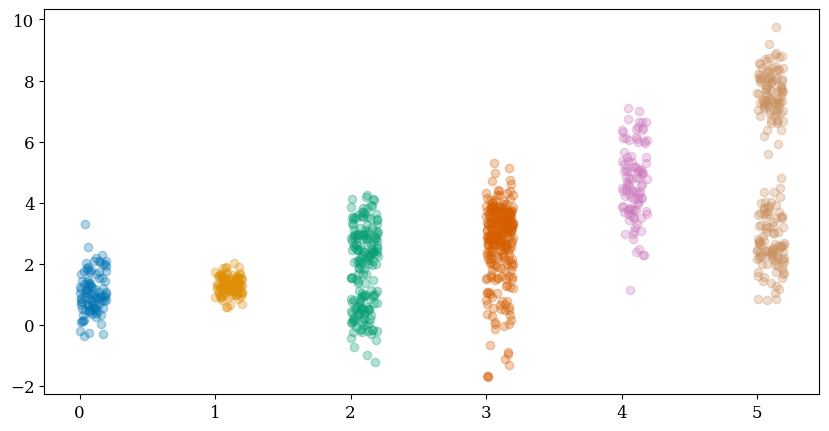

In [6]:
fig, ax = plt.subplots(ncols=1)

# I need to know the number of columns to show
n_columns = len(d.keys())
# Allow some jitter to show the data better.
jitter = 0.2

for i in range(n_columns):
    y = d[i]
    x = i+np.random.uniform(size=len(y))*jitter
    ax.scatter(x, y, alpha=0.3)


To show this using `stripplot` in seaborn we need to massage the data a bit. We need now to have one vector with all data and another with the id of each. 

In [7]:
data_vector = np.zeros(n_total_data)
label_vector = np.zeros(n_total_data, int) # This could instead be a string array for instance.

In [8]:
i_start = 0
for i in range(n_columns):
    y = d[i]
    i_end = i_start + len(y)
    data_vector[i_start:i_end] = y
    label_vector[i_start:i_end] = i
    i_start = i_end

In [9]:
ds = {'y': data_vector, 'x': label_vector}

/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='x', ylabel='y'>

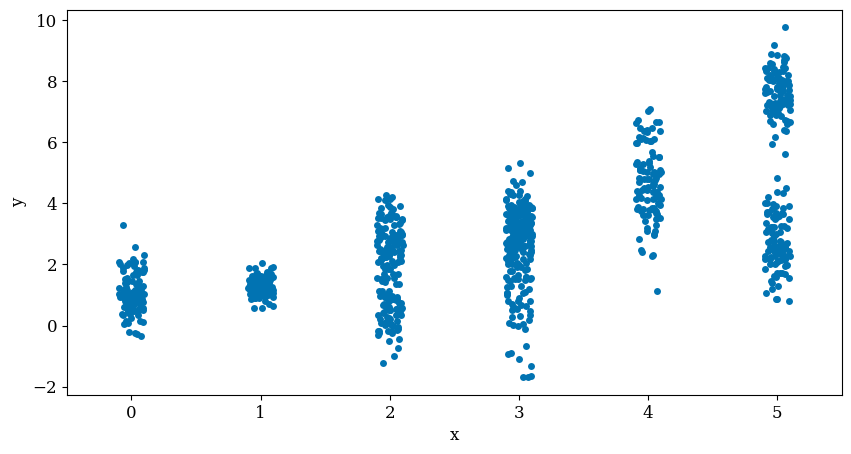

In [10]:
sns.stripplot(x='x', y='y', data=ds)

## Silly histograms

Next, try to compare these by overplotting histograms.

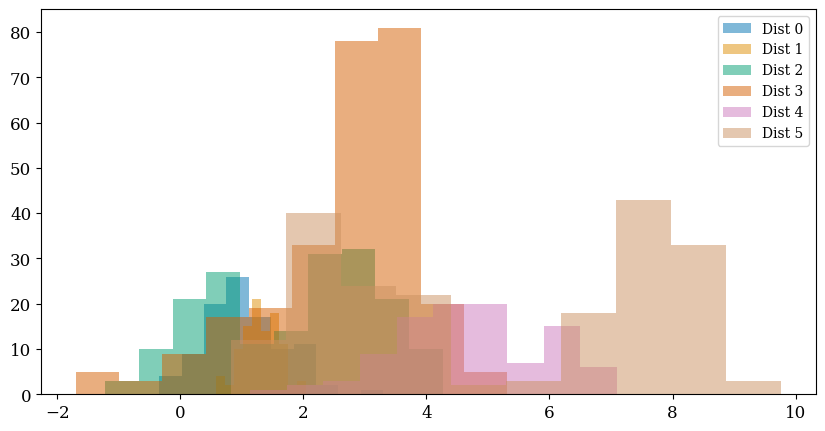

In [11]:
for i in range(len(d.keys())):
    plt.hist(d[i], label="Dist {0}".format(i), alpha=0.5)

plt.legend()

## Layered histograms

We could imagine making multiple histograms that are one above the other.

In [12]:
def plothist(x, bins='auto', yoffset=0, color=None, norm=False, peak=None,
             fill=False, ax=None, **kwargs):
    """Convenience function for manually plotting a histogram
    
    This allows for a flexible baselevel
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    
    yhist, xbins = np.histogram(x, bins=bins, density=norm)
    if peak is not None:
        yhist = peak*yhist/np.max(yhist)

    # But to get the edges of the histogram in the plot,
    # we need to pad these a bit.
    xhist = np.hstack([xbins[0], xbins, xbins[-1]])
    yhist = np.hstack([0, yhist[0], yhist, 0])
    
    try:
        col = kwargs['c']
    except:
        col = None
    
    # Finally, to make a histogram plot we use step and fill_between
    plt.step(xhist, yhist+yoffset, where='pre', **kwargs)
    if fill:
        plt.fill_between(xhist, yhist+yoffset, yoffset, step='pre', color=col)

    return ax




[]

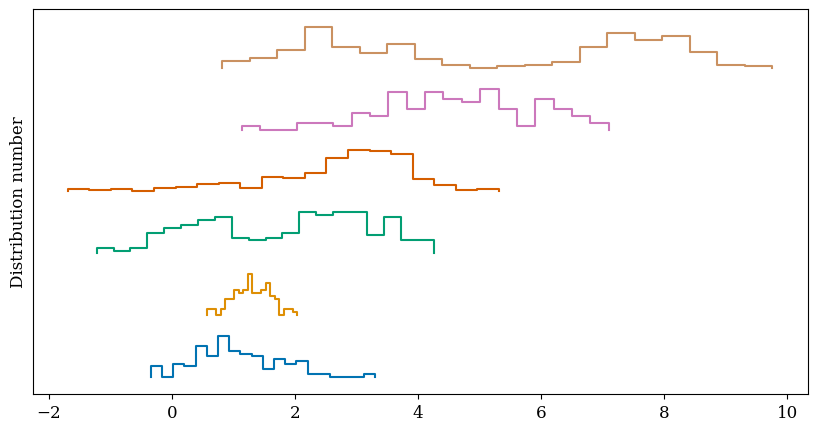

In [13]:
fig, ax = plt.subplots()

y_start = 0
dy = 1.5
for i in range(n_columns):
    plothist(d[i], yoffset=y_start+dy*i, fill=False, ax=ax, peak=1, bins=20)
    
ax.set_ylabel('Distribution number')
ax.set_yticks([])

That is not bad and might often be a good option but it does not summarise things very well.

## Better options - error bars and box plots

We can summarise things in simple ways - that gives us error bars, and the next step is box plots.

/var/folders/bj/l10yvm9m8xlgl2006s6gv0k00000gn/T/ipykernel_34868/429587438.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(xplot, means, stdevs, fmt='o', marker='o', capsize=3)


<ErrorbarContainer object of 3 artists>

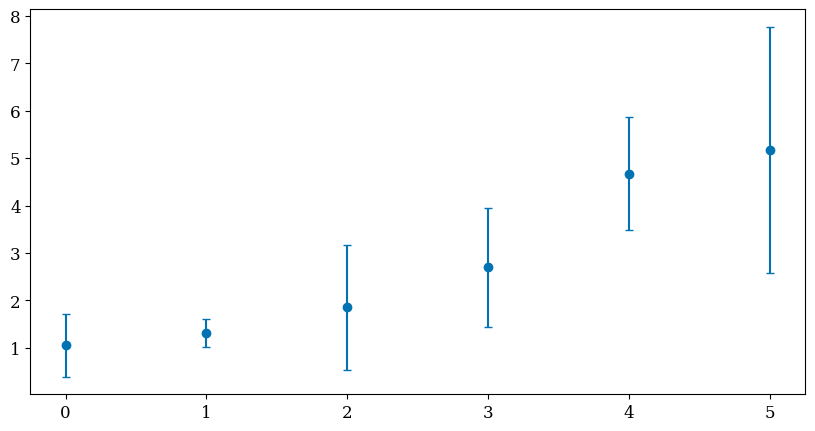

In [14]:
stdevs = np.zeros(n_columns)
means = np.zeros_like(stdevs)
for i in range(n_columns):
    stdevs[i] = np.std(d[i])
    means[i] = np.mean(d[i])

xplot = np.arange(n_columns)
plt.errorbar(xplot, means, stdevs, fmt='o', marker='o', capsize=3)

But that throws away a lot of information and makes it seem as if the errors are symmetric. We can of course improve on this, but let us instead move to box plots.

In [15]:
l = [d[i] for i in range(n_columns)]

/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/seaborn/c

<Axes: >

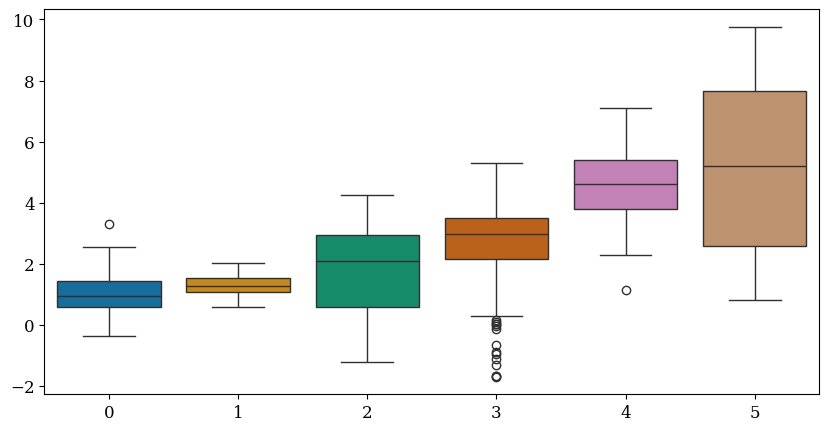

In [16]:
sns.boxplot(data=l)

<Axes: >

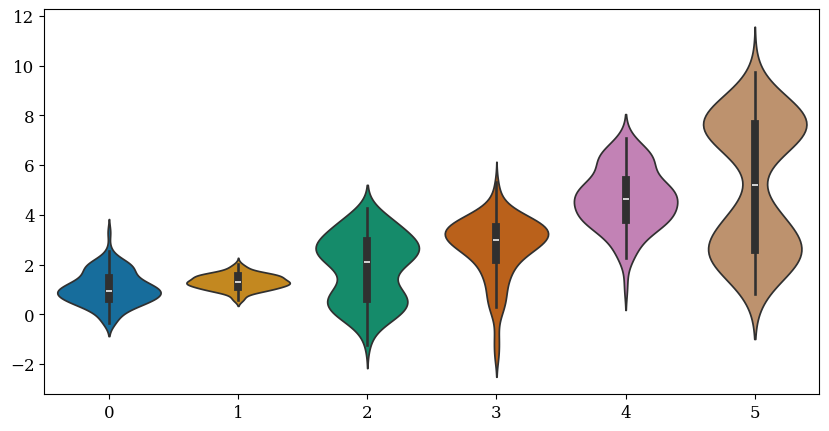

In [17]:
sns.violinplot(data=l, density_norm='width')

# Trying out 

A set of 13 datasets. The command to download the file in Colab is below - if you are running off your own machine, just copy or link the file into the directory with the notebook.

Calculate summary statistics (mean, standard deviation, correlation coefficient, maybe a linear fit) for each dataset - what do you conclude?

In [22]:
!wget --quiet -O several_datasets.tsv https://raw.githubusercontent.com/jbrinchmann/MLD2025/refs/heads/main/Datafiles/several_datasets.tsv

Astropy's table package might be a good way to read it in:

In [23]:
from astropy.table import Table
t = Table().read("several_datasets.tsv", format="ascii.fast_tab")

In [25]:
print(np.mean(t['x1'])), print(np.mean(t['y1']))

54.266099784204926
47.83472062488412


(None, None)

In [ ]:
def calculate_many(t):

    d = {'mean': np.zeros(13), 'std': np.zeros(13)}
    for i in range(1, 14):
        d['mean'][i] = np.mean(
        